import libraries

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.5 MB/s eta 0:00:00


In [2]:
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

<ipython-input-2-2e241f8e1de0>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


load and preprocess data

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

11490434/11490434 [==============================] - 0s 0us/step


build the Keras Tuner Model (CNN HyperModel)

In [6]:
# Build the Keras Tuner model
def model_builder(hp):
    model = keras.Sequential() # Initialize model

    # Tune number of convolution layers
    for i in range(hp.Int('num_conv', 1, 5)): # 1 to 6 convolution layers
        model.add(layers.Conv2D(
            filters=hp.Int('filters_' + str(i), 32, 256, step=32), # 32 to 256 filters
            kernel_size=hp.Choice('kernel_size_' + str(i), values=[3, 5]), # 3x3 or 5x5 kernel size
            activation='relu'
        ))

        # Tune pooling and dropout
        if (i % 2 == 1):
            if hp.Choice('pooling_' + str(i), values=['max', 'avg']) == 'max': # Max or average pooling
                model.add(layers.MaxPooling2D())
            else:
                model.add(layers.AveragePooling2D())

            model.add(layers.Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1))) # 0 to 0.5 dropout rate

    model.add(layers.Flatten()) # Flatten output of convolution layers

    # Tune dense layers
    for i in range(hp.Int('num_dense', 1, 4)): # 1 to 4 dense layers (in addition to output layer we have 2 to 5 layers)
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 256, step=32), activation='relu')) # 32 to 256 units
        model.add(layers.Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1))) # 0 to 0.5 dropout rate

    model.add(layers.Dense(10, activation='softmax')) # Output layer (last Dense layer)

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam( # we use Adam optimizer
            hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]) # 0.001, 0.0001, or 0.00001 learning rate
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

find best model

In [7]:
# Initialize Bayesian tuner
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy', # maximize validation accuracy
    max_trials=12, # Runtime will be very high if this is increased
    directory='my_dir',
    project_name='mnist_tuner'
)

# Perform Bayesian hyperparameter search
tuner.search(x_train, y_train, # Train on training set
             epochs=4, # 4 epochs per trial
             validation_data=(x_test, y_test)) # Evaluate on test set

# Get best model
best_model = tuner.get_best_models(num_models=1)[0] # Get best model

# get best model hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] # Get best hyperparameters
print(f"""
    The hyperparameter search is complete.\n
    The optimal number of convolution layers is {best_hps.get('num_conv')},\n
    the optimal number of dense layers is {best_hps.get('num_dense')}, \n
    the optimal learning rate for the optimizer is {best_hps.get('learning_rate')},\n
""")

Trial 12 Complete [00h 01m 24s]
val_accuracy: 0.9857000112533569

Best val_accuracy So Far: 0.9922000169754028
Total elapsed time: 00h 14m 46s

    The hyperparameter search is complete.

    The optimal number of convolution layers is 4,

    the optimal number of dense layers is 2, 

    the optimal learning rate for the optimizer is 0.0001,
 



In [8]:
print("best hyperparameters found by tuner:")
best_hps.values

best hyperparameters found by tuner:


{'num_conv': 4,
 'filters_0': 64,
 'kernel_size_0': 3,
 'pooling_0': 'avg',
 'dropout_0': 0.0,
 'num_dense': 2,
 'units_0': 160,
 'learning_rate': 0.0001,
 'filters_1': 224,
 'kernel_size_1': 3,
 'filters_2': 256,
 'kernel_size_2': 5,
 'pooling_2': 'avg',
 'dropout_2': 0.1,
 'units_1': 224,
 'dropout_1': 0.4,
 'filters_3': 160,
 'kernel_size_3': 5,
 'units_2': 192,
 'filters_4': 96,
 'kernel_size_4': 3,
 'pooling_4': 'avg',
 'dropout_4': 0.1,
 'units_3': 256,
 'dropout_3': 0.4,
 'pooling_1': 'max',
 'pooling_3': 'max'}

train best model and evaluate it on test data

In [9]:
# Train best model on entire training set
history = best_model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 25s 15ms/step - loss: 0.0320 - accuracy: 0.9904 - val_loss: 0.0205 - val_accuracy: 0.9933
Epoch 2/10
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0273 - accuracy: 0.9919 - val_loss: 0.0193 - val_accuracy: 0.9944
Epoch 3/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0193 - val_accuracy: 0.9949
Epoch 4/10
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0213 - val_accuracy: 0.9939
Epoch 5/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.0336 - val_accuracy: 0.9915
Epoch 6/10
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0252 - val_accuracy: 0.9945
Epoch 7/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0146 - accuracy: 0.9956 - val_loss: 0.0227 -

In [10]:
# Print structure of best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 26, 26, 64)          640       
                                                                 
 conv2d_1 (Conv2D)           (32, 24, 24, 224)         129248    
                                                                 
 max_pooling2d (MaxPooling2  (32, 12, 12, 224)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 12, 12, 224)         0         
                                                                 
 conv2d_2 (Conv2D)           (32, 8, 8, 256)           1433856   
                                                                 
 conv2d_3 (Conv2D)           (32, 4, 4, 160)           1024160   
                                                        

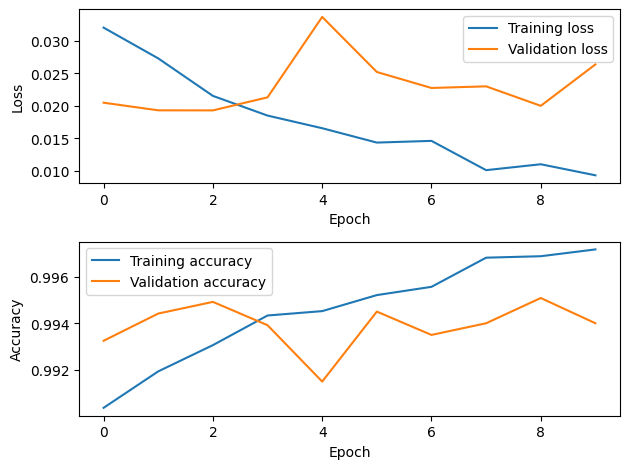

In [11]:
# plot training loss and validation loss over epochs and training accuracy and validation accuracy over epochs in 2 subplots
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Evaluate the best model on the test set
eval_result = best_model.evaluate(x_test, y_test) # Evaluate on test set

print("Test accuracy:", eval_result[1])
print("Test loss:", eval_result[0])

313/313 [==============================] - 2s 7ms/step - loss: 0.0235 - accuracy: 0.9936
Test accuracy: 0.9936000108718872
Test loss: 0.023486066609621048
